In [6]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

### Train Dataset

In [ ]:
## Read here PA train
path_to_pa_train = "/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/PresenceAbsenceSurveys/GLC24-PA-metadata-train.csv" 

pa = pd.read_csv(path_to_pa_train)
pa.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476.0,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157.0,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784.0,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530.0,212


## Filter

- Filter to France

- Filter to top 10 species 


We are filtering out the rarely observed plant species in PA surveys

In [3]:
## Filter France
pafr = pa.loc[pa["country"]=="France"]

## Filter for the top10 species
filter_list = pafr["speciesId"].value_counts().head(1).index.to_list()

## Filter to the selected species
positive = pafr.loc[pafr["speciesId"].isin(filter_list)]

## drop duplicate surveyId
positive = positive.drop_duplicates(subset="surveyId")

print(f"Specie Selected: {positive["speciesId"].unique()[0]}")
print(f"Shape of the positive df: {positive.shape}")


## NEGATIVE -----------------------
## Get a list with surveyId with presence of the choice specie
surveyId_postive = positive["surveyId"].value_counts().index.to_list()

## get the inverted list of survey Id
negative_surveyId = pafr["surveyId"].loc[~pafr["surveyId"].isin(surveyId_postive)].unique()

## Create a France df with the negative surveyId
negative = pafr.loc[pafr["surveyId"].isin(negative_surveyId)]

## Drop duplicated survey Id
negative = negative.drop_duplicates(subset="surveyId")

print(f"Shape of the negative df: {negative.shape}")

print(f"Number of Unique surveyId in France: {len(pafr["surveyId"].unique())}")
print(f"Sum of neg+pos: {positive.shape[0]+negative.shape[0]}")

## Concat the positive and negative
final_df_train = pd.concat([positive,negative],axis=0)

print(f"Shape of the final dataset: {final_df_train.shape}")

Specie Selected: 2474.0
Shape of the positive df: (6180, 9)
Shape of the negative df: (7321, 9)
Number of Unique surveyId in France: 13501
Sum of neg+pos: 13501
Shape of the final dataset: (13501, 9)


In [4]:
final_df_train.head()

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
41,-0.51736,45.80643,2017,1.0,NaN,ATLANTIC,France,2474.0,333
84,5.61448,47.21759,2019,1.0,NaN,CONTINENTAL,France,2474.0,410
330,1.70039,47.64019,2019,1.0,NaN,ATLANTIC,France,2474.0,779
502,2.71272,47.76724,2018,1.0,NaN,ATLANTIC,France,2474.0,1218
659,4.37398,44.47449,2019,1.0,NaN,MEDITERRANEAN,France,2474.0,2015


In [8]:
## Save 
folder_output = "/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/"
file_output = "train_metadata.parquet"

final_df_train.to_parquet(os.path.join(folder_output, file_output),
                          engine="fastparquet")

### Test Metadata

In [9]:
## Labels
labels = pd.read_csv("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/test_labels.csv")

## Test metadata PA 
test_df = pd.read_csv("/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/PresenceAbsenceSurveys/GLC24-PA-metadata-test.csv")

## Concat
new_df = pd.concat([labels.set_index("surveyId"), test_df.set_index("surveyId")],axis=1)

new_df.reset_index(inplace=True)

## Find specie
new_df['species_list'] = new_df['predictions'].apply(lambda x:[int(i) for i in x.split()])

specie = 2474

def find_specie(x):
    if specie in x:
        return 1
    else:
        return 0
    
new_df['contain_specie'] = new_df['species_list'].apply(lambda x: find_specie(x))


#Only France
new_df = new_df.loc[new_df["country"]=="France"]




In [10]:
folder_output = "/mnt/d/desktop/COPERNICUS/Classes/3-semester/ml/species/output/"
file_output = "test_metadata.parquet"

new_df.to_parquet(os.path.join(folder_output, file_output),
                          engine="fastparquet")


## Plots

In [ ]:
## gdf only France
gdf_test = gpd.GeoDataFrame(new_df,
                            geometry = gpd.points_from_xy(new_df["lon"],
                                                     new_df["lat"]),
                       crs="EPSG:4326")

gdf = gpd.GeoDataFrame(final_df_train, 
                       geometry = gpd.points_from_xy(final_df_train["lon"],
                                                     final_df_train["lat"]),
                       crs="EPSG:4326")

## Select specie 
def if_else(x):
    if int(x)==2474:
        return 1
    else:
        return 0
gdf['predict']= gdf['speciesId'].apply(lambda x: if_else(x))

gdf_test['predict'] = gdf_test['contain_specie']

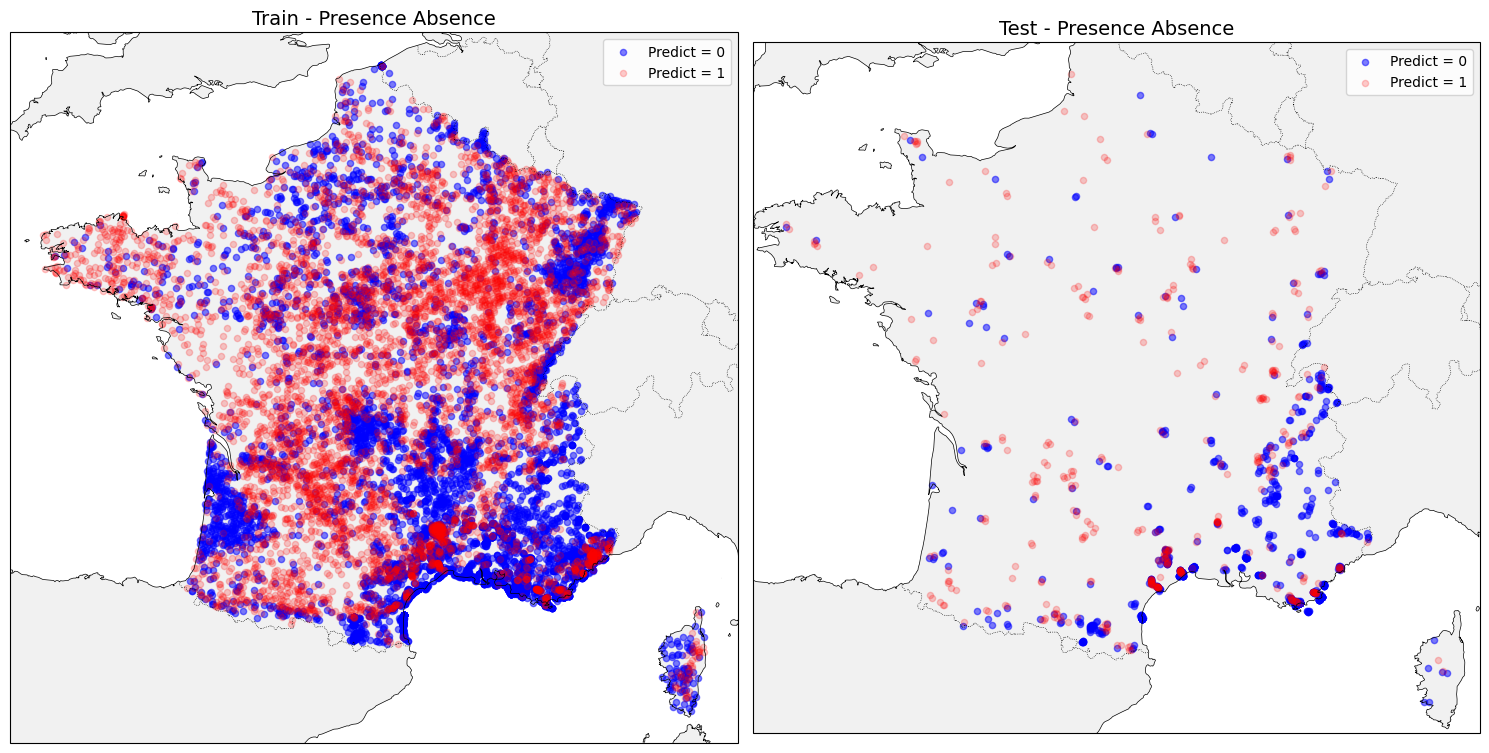

In [21]:
# Create the plot

fig, ax = plt.subplots(nrows=1,ncols=2,
    figsize=(15, 15),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax[0].add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax[0].add_feature(cfeature.COASTLINE, linewidth=0.5) 
ax[1].add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax[1].add_feature(cfeature.COASTLINE, linewidth=0.5) 

### TRAIN
gdf[gdf['predict'] == 0].plot(
    ax=ax[0],
    color='blue',
    alpha=0.5,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 0'
)

# Plot points where predict = 1
gdf[gdf['predict'] == 1].plot(
    ax=ax[0],
    color='red',
    alpha=0.2,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 1'
)

ax[0].set_title('Train - Presence Absence', fontsize=14)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()


### TESTE 
gdf_test[gdf_test['predict'] == 0].plot(
    ax=ax[1],
    color='blue',
    alpha=0.5,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 0'
)

# Plot points where predict = 1
gdf_test[gdf_test['predict'] == 1].plot(
    ax=ax[1],
    color='red',
    alpha=0.2,  # Transparency value (0-1)
    markersize=20,
    label='Predict = 1'
)

ax[1].set_title('Test - Presence Absence', fontsize=14)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()

In [25]:
new_df['predict'] =new_df['contain_specie']

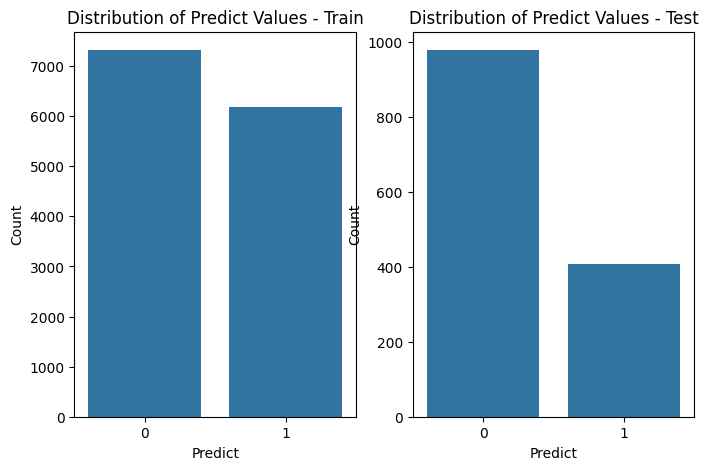

In [29]:
## preprocess 
new_df['predict'] =new_df['contain_specie']
def if_else(x):
    if int(x)==2474:
        return 1
    else:
        return 0
final_df_train['predict']= final_df_train['speciesId'].apply(lambda x: if_else(x))


## PLOT
fig, ax = plt.subplots(nrows=1,ncols=2,
    figsize=(8,5),
)

counts = final_df_train['predict'].value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax[0])
ax[0].set_title('Distribution of Predict Values - Train')
ax[0].set_xlabel('Predict')
ax[0].set_ylabel('Count')

counts_t = new_df['predict'].value_counts()
sns.barplot(x=counts_t.index, y=counts_t.values, ax=ax[1])
ax[1].set_title('Distribution of Predict Values - Test')
ax[1].set_xlabel('Predict')
ax[1].set_ylabel('Count')
plt.show()